GPU

In [1]:
!nvidia-smi

Sun Sep 17 12:51:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importing Libraries

In [2]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm.auto import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import cv2
from skimage.io import imread, imshow, show

from tensorflow import keras
from keras import layers

seed = 42
np.random.seed = seed  # To get same random seed everytime we run the whole thing.
random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.5 MB/s eta 0:00:00


In [4]:
import tensorflow_addons as tfa

## Drive Mount

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [6]:
H1_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H1/*"
H2_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H2/*"
H3_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H3/*"
H5_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H5/*"
H6_path = "/content/drive/MyDrive/ICCIT 2023/Dataset/H6/*"

In [7]:
def sorted_file_paths(path):
    file_paths = sorted(glob(path))
    print("Total image files:")
    print(f"{len(file_paths)} \n")
    return file_paths

H1_file_paths = sorted_file_paths(H1_path)
H2_file_paths = sorted_file_paths(H2_path)
H3_file_paths = sorted_file_paths(H3_path)
H5_file_paths = sorted_file_paths(H5_path)
H6_file_paths = sorted_file_paths(H6_path)

Total image files:
4357 

Total image files:
2314 

Total image files:
816 

Total image files:
814 

Total image files:
739 



In [8]:
def random_image_paths(num, paths):

    random.seed(46)         # Fixed seed every time
    length = len(paths)     # number of all files

    idx = np.array(random.sample(range(length), num))

    filtered = np.array(paths)[idx]

    if np.unique(filtered).shape[0] != num:
        print("Something Wrong")
        return
    return filtered.tolist()


H1_700_paths = random_image_paths(700, H1_file_paths)
H2_700_paths = random_image_paths(700, H2_file_paths)
H3_700_paths = random_image_paths(700, H3_file_paths)
H5_700_paths = random_image_paths(700, H5_file_paths)
H6_700_paths = random_image_paths(700, H6_file_paths)

print(len(H1_700_paths),len(H2_700_paths),len(H3_700_paths),len(H5_700_paths),len(H6_700_paths) )

all_3500_paths = H1_700_paths + H2_700_paths + H3_700_paths + H5_700_paths + H6_700_paths

print(type(all_3500_paths))
print(len(all_3500_paths))
print(all_3500_paths[50])
print(all_3500_paths[750])
print(all_3500_paths[3400])

700 700 700 700 700
<class 'list'>
3500
/content/drive/MyDrive/ICCIT 2023/Dataset/H1/H1_70a_4.jpg
/content/drive/MyDrive/ICCIT 2023/Dataset/H2/H2_15b_16.jpg
/content/drive/MyDrive/ICCIT 2023/Dataset/H6/H6_33a_11.jpg


In [9]:
def image_preprocess(paths):
    total = len(paths)
    im_array = np.zeros((total, 128, 128, 3), dtype = np.float32)
    for i in tqdm(range(total)):
        img = imread(paths[i])  # Numpy Array = (500,500,3)
        # print(image.shape)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0       # Normalization to float64
        im_array[i, :, :, :] = img
    return im_array

# Normalized [0, 1] and (128, 128, 3) shaped float32 images.
# X = image_preprocess(all_3500_paths)
X = np.load("/content/drive/MyDrive/ICCIT 2023/npy_files/array_3500.npy")
print(X.shape)
print(X.dtype)

(3500, 128, 128, 3)
float32


In [ ]:

# np.save("/content/drive/MyDrive/ICCIT 2023/npy_files/array_3500.npy", X)

In [10]:
labels = ['H1']*700 + ['H2']*700 + ['H3']*700 + ['H5']*700 + ['H6']*700
print(type(labels))
print(len(labels))
print(labels[3300])
# print(labels)

<class 'list'>
3500
H6


In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(labels)
print(y.shape)
print(y)
print('\n')


classes = list(label_enconder.classes_)
print(classes)
print('\n')

(3500,)
[0 0 0 ... 4 4 4]


['H1', 'H2', 'H3', 'H5', 'H6']




In [12]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(X.dtype, y.dtype)
# All are 4D and 1D array.

(3500, 128, 128, 3) (3500,)
float32 float32


## Model creation

In [13]:
input_shape = (128, 128, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024]

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [15]:
def create_vit_classifier(layer):
    input_shape = (128, 128, 3)
    num_classes = 5

    inputs = layers.Input(shape=input_shape)

    augmented = layer(inputs)

    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes, activation='softmax')(features)

    model = keras.Model(inputs=inputs, outputs=logits)

    return model


In [16]:
model = create_vit_classifier(data_augmentation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches[0][0]']         

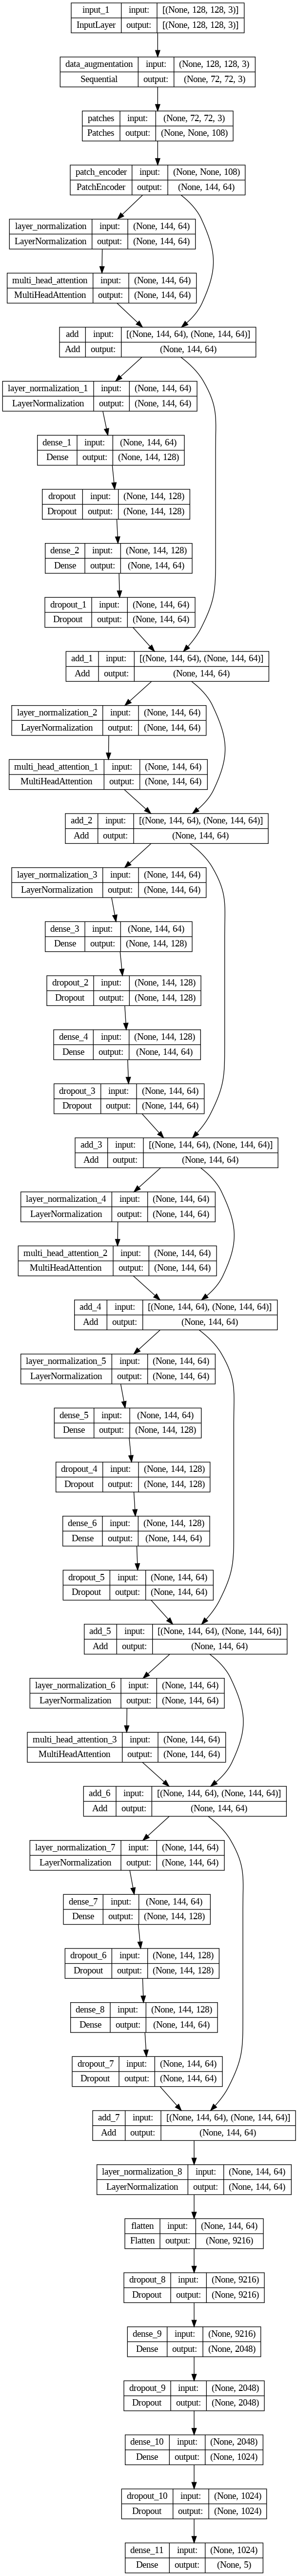

In [17]:

tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [18]:
def metric_calculation(true, out):

    f1_metric = tf.keras.metrics.F1Score()
    f1_metric.update_state(true, out)
    f1_scores = f1_metric.result().numpy()
    f1 = np.mean(f1_scores)

    pred = np.zeros((true.shape[0],5))
    for i in range(true.shape[0]):
        indx = np.argmax(out[i,:])
        pred[i,indx] = 1

    recall_scores = []
    pre_scores =[]
    for i in range(3):
        re_metric = tf.keras.metrics.Recall()
        pre_metric = tf.keras.metrics.Precision()
        re_metric.update_state(true[:,i],pred[:,i])
        pre_metric.update_state(true[:,i],pred[:,i])

        recall_scores.append(re_metric.result().numpy())
        pre_scores.append(pre_metric.result().numpy())

    recall = np.mean(np.array(recall_scores))
    precision = np.mean(np.array(pre_scores))

    return precision, recall, f1

In [19]:
xx = np.array([[1, 0, 0],
               [1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])
yy = np.array([[0.9, 0.05, 0.05],
               [0.1, 0.8, 0.1],
               [0.2, 0.7, 0.1],
               [0.2, 0.2, 0.6]])
a, b, c = metric_calculation(xx, yy)
print(a, b, c)

0.8333333 0.8333333 0.77777785


In [20]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
history_all = []
f1_all = []
pre_all = []
rec_all = []

for train, test in cv.split(X, y):

    print('   ')
    print(f'Training for fold {fold_no} ...', '\n')

    x_train = X[train]
    x_test = X[test]
    y_train = y[train]
    y_test = y[test]

    y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

    data_augmentation = keras.Sequential([layers.Normalization(),
                                          layers.Resizing(image_size, image_size),
                                          layers.RandomFlip("horizontal"),
                                          layers.RandomRotation(factor=0.02),
                                          layers.RandomZoom(height_factor=0.2, width_factor=0.2)],
                                          name="data_augmentation")


    data_augmentation.layers[0].adapt(x_train)

    model = create_vit_classifier(data_augmentation)

    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
                                     weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_test, y_test))

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%", '\n')

    prediction = model.predict(x_test)
    pre, rec, f1 = metric_calculation(y_test, prediction)

    print(f"F1 Score: {round(f1 * 100, 2)}%", '\n')
    print(f"Precision: {round(pre * 100, 2)}%", '\n')
    print(f"Recall: {round(rec * 100, 2)}%", '\n')

    acc_per_fold.append(accuracy*100)
    f1_all.append(f1)
    pre_all.append(pre)
    rec_all.append(rec)
    history_all.append(history)

    fold_no = fold_no + 1

   
Training for fold 1 ... 

Epoch 1/100
88/88 [==============================] - 12s 31ms/step - loss: 2.9560 - accuracy: 0.4096 - val_loss: 1.2142 - val_accuracy: 0.5229
Epoch 2/100
88/88 [==============================] - 2s 20ms/step - loss: 1.2507 - accuracy: 0.5268 - val_loss: 1.0134 - val_accuracy: 0.5757
Epoch 3/100
88/88 [==============================] - 2s 20ms/step - loss: 1.0349 - accuracy: 0.6032 - val_loss: 0.8450 - val_accuracy: 0.6643
Epoch 4/100
88/88 [==============================] - 2s 21ms/step - loss: 0.9582 - accuracy: 0.6168 - val_loss: 0.9111 - val_accuracy: 0.6729
Epoch 5/100
88/88 [==============================] - 2s 21ms/step - loss: 0.8998 - accuracy: 0.6386 - val_loss: 0.8981 - val_accuracy: 0.6114
Epoch 6/100
88/88 [==============================] - 2s 20ms/step - loss: 0.8995 - accuracy: 0.6400 - val_loss: 0.8404 - val_accuracy: 0.6271
Epoch 7/100
88/88 [==============================] - 2s 20ms/step - loss: 0.8529 - accuracy: 0.6632 - val_loss: 0.826

## Analysis

In [21]:
print(acc_per_fold, '\n')

mean = np.mean(np.array(acc_per_fold))
std = np.std(np.array(acc_per_fold))

print(f"Overall Accuracy is : {mean}+-{std}")

[76.28571391105652, 75.42856931686401, 76.14285945892334, 73.71428608894348, 75.57142972946167] 

Overall Accuracy is : 75.4285717010498+-0.9169605602625837


In [22]:
print(f1_all, '\n')

mean = np.mean(np.array(f1_all))
std = np.std(np.array(f1_all))

print(f"F1 Score is : {mean}+-{std}")

[0.76922977, 0.75194466, 0.76321256, 0.7378567, 0.75385755] 

F1 Score is : 0.7552202939987183+-0.01071656122803688


In [23]:
print(pre_all, '\n')

mean = np.mean(np.array(pre_all))
std = np.std(np.array(pre_all))

print(f"Precision is : {mean}+-{std}")

[0.681235, 0.669642, 0.69803506, 0.6414663, 0.6632275] 

Precision is : 0.670721173286438+-0.018813589587807655


In [24]:
print(rec_all, '\n')

mean = np.mean(np.array(rec_all))
std = np.std(np.array(rec_all))

print(f"Recall is : {mean}+-{std}")

[0.6714286, 0.64047617, 0.65476185, 0.6238095, 0.65238094] 

Recall is : 0.6485714316368103+-0.015836481004953384


## History an File Saving to Numpy Array

In [25]:
history_nparray = np.zeros((20, 100))
print(len(history_all[0].history))

count = 0

for k in tqdm(range(5)):

    aa = history_all[k].history      # Dictionary

    history_nparray[count, :] = np.array(aa['loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['accuracy'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_accuracy'])
    count = count+1

print(count)
print(history_nparray[-1,:])

4


  0%|          | 0/5 [00:00<?, ?it/s]

20
[0.49714285 0.61000001 0.63       0.62142855 0.64428574 0.67714286
 0.64428574 0.70857143 0.67428571 0.67000002 0.67285717 0.69142854
 0.69142854 0.69       0.64714283 0.72000003 0.68000001 0.67571431
 0.72285712 0.70999998 0.72142857 0.62857145 0.74142855 0.72142857
 0.64857143 0.71285713 0.72857141 0.72857141 0.72714287 0.72142857
 0.71714288 0.73000002 0.73714286 0.70285714 0.70571429 0.72714287
 0.73142856 0.74285716 0.72285712 0.72000003 0.71571428 0.72714287
 0.72428572 0.74000001 0.76428574 0.70857143 0.74285716 0.7557143
 0.7557143  0.75857145 0.74142855 0.75285715 0.76428574 0.73000002
 0.7442857  0.76857144 0.76571429 0.77571428 0.75428569 0.74285716
 0.75285715 0.75       0.76857144 0.7557143  0.75714284 0.76285714
 0.74714285 0.74142855 0.77285713 0.74142855 0.78428572 0.78285712
 0.77142859 0.76142859 0.73857141 0.74857146 0.77571428 0.76428574
 0.77428573 0.76142859 0.74857146 0.77142859 0.75999999 0.74571431
 0.76142859 0.76285714 0.76285714 0.75714284 0.76857144 0.71

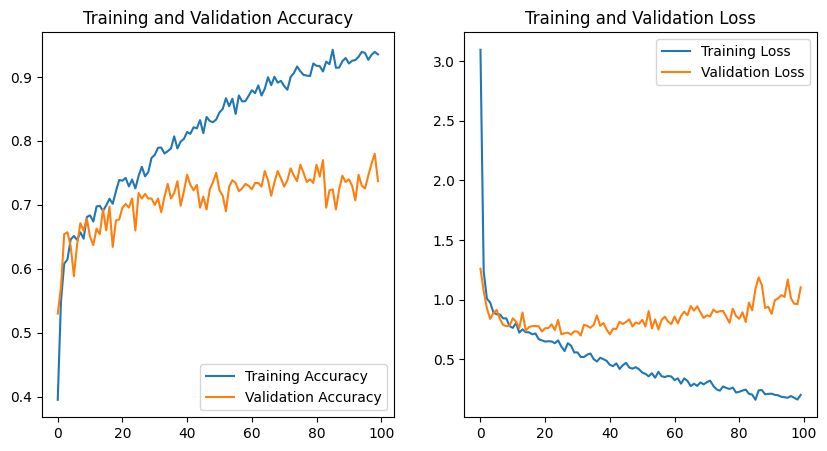

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(100), history_nparray[13,:], label='Training Accuracy')
plt.plot(range(100), history_nparray[15,:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), history_nparray[12,:], label='Training Loss')
plt.plot(range(100), history_nparray[14,:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
np.save('/content/ViT_3500_History.npy', history_nparray)

acc_f1_pre_rec = np.zeros((4,5))
acc_f1_pre_rec[0,:] = np.array(acc_per_fold)
acc_f1_pre_rec[1,:] = np.array(f1_all)
acc_f1_pre_rec[2,:] = np.array(pre_all)
acc_f1_pre_rec[3,:] = np.array(rec_all)

np.save('/content/ViT_3500_Acc_F1_Pre_Rec.npy', acc_f1_pre_rec)